# LangChain Data Demo

_2023-04-01_

**By Matt Hodges**

This Jupyter Notebook demonstrates a variety of data tasks that can be accomplished with the assistance of the [LangChain](https://python.langchain.com/en/latest/index.html) framework. It shows how you can utilize [Chains](https://python.langchain.com/en/latest/modules/chains/getting_started.html), [Agents](https://python.langchain.com/en/latest/modules/agents/getting_started.html), and [Tools](https://python.langchain.com/en/latest/modules/agents/tools/getting_started.html) to work with voter data.

LangChain is a flexible framework that can integrate with a [variety of LLMs](https://python.langchain.com/en/latest/reference/integrations.html). This Notebook integrates with OpenAI. To continue, obtain an [OpenAI API Key](https://platform.openai.com/). Copy the `.env.example` file to `.env` at the root of this respository, and set your key there. Since it can be hard to gauge utilization, I also recommend setting spending limits on your OpenAI account.

This Notebook was written with LangChain version `0.0.128` using the `text-davinci-003` model from OpenAI.

Also, be sure to install the requirements defined in `requirements.txt`:

```
pip install -r requirements.txt
```

## Gathering Data

This Notebook utilizes the [public voter data](https://dl.ncsbe.gov/index.html?prefix=data/) provided by the North Carolina State Board of Elections. We will work with a small subset of the NC voter file.

In [2]:
import sqlite3
import tempfile
import urllib.request
import zipfile

import dotenv
import pandas as pd
from langchain import LLMChain, OpenAI, SQLDatabase, SQLDatabaseChain
from langchain.agents import (AgentExecutor, Tool, ZeroShotAgent,
                              initialize_agent, load_tools)

dotenv.load_dotenv(override=False)

True

Loading the data into the database is the most code we'll write in this project:

In [2]:
# Public data from NC Elections Board
# https://dl.ncsbe.gov/index.html?prefix=data/
nc_voter_url = "https://s3.amazonaws.com/dl.ncsbe.gov/data/ncvoter29.zip"
nc_vhis_url = "https://s3.amazonaws.com/dl.ncsbe.gov/data/ncvhis29.zip"


# Download the data and extract the Zip
extracted = []
for datafile in (nc_voter_url, nc_vhis_url):

    with tempfile.NamedTemporaryFile(suffix=".zip") as tmp_file:
        urllib.request.urlretrieve(datafile, tmp_file.name)

        with zipfile.ZipFile(tmp_file.name, "r") as zip_ref:
            zip_ref.extractall("./data/")
            extracted += zip_ref.namelist()

# Load the data into a local SQLite database
# We are not concerned with setting Primary Keys or Foreign Keys
for filename in extracted:
    table_name = filename.split(".")[0]
    path = f"./data/{filename}"

    df = pd.read_csv(path, delimiter="\t", encoding="latin1")
    cols = list(df.columns)
    preliminary_col_types = [str(dt) for dt in list(df.dtypes)]
    col_types = []
    for col in preliminary_col_types:
        if col == "int64":
            col_types.append("INTEGER")
        elif col == "float64":
            col_types.append("REAL")
        else:
            col_types.append("TEXT")

    column_def = ', '.join([f"{col} {t}" for col, t in zip(cols, col_types)])

    con = sqlite3.connect("./data/ncv.db")
    cur = con.cursor()
    cur.execute(f"CREATE TABLE IF NOT EXISTS {table_name} ({column_def});")

    df.to_sql(table_name, con, if_exists="replace", index=False)
    con.commit()
    con.close()

## Using the LLM to Write and Run SQL

Now that our voter data is loaded into the database, we're ready to start working with it! We'll start by using the [SQLDatabaseChain](https://python.langchain.com/en/latest/modules/chains/examples/sqlite.html). We'll use it to craft and execute SQL queries. And we'll set it to `verbose` so that we can see and verify its work.

**NOTE:** For data-sensitive projects, you can specify `return_direct=True` in the SQLDatabaseChain initialization to directly return the output of the SQL query without any additional formatting. This prevents the LLM from seeing any additional contents within the database (though it does default [init with 3 sample rows](https://github.com/hwchase17/langchain/blob/v0.0.128/langchain/sql_database.py#L22)). Note, however, the LLM still has access to the database scheme (i.e. dialect, table and key names) by default. If this were not set, the results of the query would be sent to the LLM for further summarization.

In [4]:
db = SQLDatabase.from_uri("sqlite:///./data/ncv.db")
llm = OpenAI(temperature=0)
db_chain = SQLDatabaseChain(
    llm=llm,
    database=db,
    verbose=True,  # Show its work
    return_direct=True,  # Return the results without sending back to the LLM
)

And now we're ready to roll! Let's try a few!

In [4]:
db_chain("How many voters are there?")



> Entering new SQLDatabaseChain chain...
How many voters are there? 
SQLQuery: SELECT COUNT(*) FROM ncvoter29;
SQLResult: [(125937,)]
> Finished chain.


{'query': 'How many voters are there?', 'result': '[(125937,)]'}

In [6]:
db_chain("What is the average age for each party?")



> Entering new SQLDatabaseChain chain...
What is the average age for each party? 
SQLQuery: SELECT party_cd, AVG(age_at_year_end) FROM ncvoter29 GROUP BY party_cd;
SQLResult: [('DEM', 57.10139401882521), ('GRE', 20.0), ('LIB', 38.924418604651166), ('REP', 55.279202607493254), ('UNA', 47.284671532846716)]
> Finished chain.


{'query': 'What is the average age for each party?',
 'result': "[('DEM', 57.10139401882521), ('GRE', 20.0), ('LIB', 38.924418604651166), ('REP', 55.279202607493254), ('UNA', 47.284671532846716)]"}

In [7]:
db_chain("What is the most common first name of DEM voters who voted in 2020?")



> Entering new SQLDatabaseChain chain...
What is the most common first name of DEM voters who voted in 2020? 
SQLQuery: SELECT first_name, COUNT(*) AS count FROM ncvoter29 JOIN ncvhis29 ON ncvoter29.voter_reg_num = ncvhis29.voter_reg_num WHERE ncvhis29.election_lbl = '11/03/2020' AND ncvoter29.party_cd = 'DEM' GROUP BY first_name ORDER BY count DESC LIMIT 5;
SQLResult: [('JAMES', 268), ('MARY', 221), ('ROBERT', 215), ('MICHAEL', 174), ('WILLIAM', 167)]
> Finished chain.


{'query': 'What is the most common first name of DEM voters who voted in 2020?',
 'result': "[('JAMES', 268), ('MARY', 221), ('ROBERT', 215), ('MICHAEL', 174), ('WILLIAM', 167)]"}

In [8]:
db_chain("The unique id is ncid. How many voters have no voting history?")



> Entering new SQLDatabaseChain chain...
The unique id is ncid. How many voters have no voting history? 
SQLQuery: SELECT COUNT(DISTINCT ncvoter29.ncid) FROM ncvoter29 LEFT JOIN ncvhis29 ON ncvoter29.ncid = ncvhis29.ncid WHERE ncvhis29.ncid IS NULL;
SQLResult: [(18215,)]
> Finished chain.


{'query': 'The unique id is ncid. How many voters have no voting history?',
 'result': '[(18215,)]'}

## Using the LLM to Visualize the Data

This is really cool! As you can see, we didn't have to actually tell the LLM much about the database to start querying it with natural language. It was able to infer the schema largely on its own!

But the power here doesn't stop just at writing and executing SQL. We can actually _chain_ more utility. Let's get the LLM to use Python to do some data viz. To do that, we'll leverage the [Python REPL](https://python.langchain.com/en/latest/modules/agents/tools/examples/python.html) tool, and define a [custom agent](https://python.langchain.com/en/latest/modules/agents/agents/custom_agent.html) that uses our SQLite database as a tool.

⚠️ **NOTE:** this executes LLM-generated Python code! This can be bad if the LLM-generated Python code is harmful. You may wish to execute this in a Virtual Machine or other sandboxed environment.

In [5]:
# Add python_repl to our list of tools
tools = load_tools(["python_repl"])

# Define our voter_data tool

# Set a description to help the LLM know when and how to use it.
description = (
    "Useful for when you need to answer questions about voters. "
    "You must not input SQL. Use this more than the Python tool if the question "
    "is about voter data, like 'how many DEM voters are there?' or 'count the number of precincts'"
)

voter_data = Tool(
    name="Data",  # We'll just call it 'Data'
    func=db_chain.run,
    description=description,
)

tools.append(voter_data)

We create the custom agent by working with the `ZeroShotAgent`. Most of the modifications come from updating the prompt and specifying the tools.

In [11]:
# Standard prefix
prefix = "Fulfill the following request as best you can. You have access to the following tools:"

# Remind the agent of the Data tool, and what types of input it expects
suffix = (
    "Begin! When looking for data, do not write a SQL query. "
    "Pass the relevant portion of the request directly to the Data tool in its entirety."
    "\n\n"
    "Request: {input}\n"
    "{agent_scratchpad}"
)

# The agent's prompt is built with the list of tools, prefix, suffix, and input variables
prompt = ZeroShotAgent.create_prompt(
    tools, prefix=prefix, suffix=suffix, input_variables=["input", "agent_scratchpad"]
)

# Set up the llm_chain
llm_chain = LLMChain(llm=llm, prompt=prompt)

# Specify the tools the agent may use
tool_names = [tool.name for tool in tools]
agent = ZeroShotAgent(llm_chain=llm_chain, allowed_tools=tool_names)

# Create the AgentExecutor
agent_executor = AgentExecutor.from_agent_and_tools(
    agent=agent, tools=tools, verbose=True
)

And we can look at the prompt:

In [12]:
print(prompt.template)

Fulfill the following request as best you can. You have access to the following tools:

Python REPL: A Python shell. Use this to execute python commands. Input should be a valid python command. If you want to see the output of a value, you should print it out with `print(...)`.
Data: Useful for when you need to answer questions about voters. You must not input SQL. Use this more than the Python tool if the question is about voter data, like 'how many DEM voters are there?' or 'count the number of precints'

Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [Python REPL, Data]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question

Begin! When looking for data, do not write a SQL query

Now let's give it a go! Below you can see the choice the agent makes based on its inputs and observations. Here it decides to query the database, pass the results to python, and utilize `matplotlib` to graph a chart.



> Entering new AgentExecutor chain...

Thought: I need to find the most common first names of DEM voters who voted in 2020
Action: Data
Action Input: Find the most common first names of DEM voters who voted in 2020

> Entering new SQLDatabaseChain chain...
Find the most common first names of DEM voters who voted in 2020 
SQLQuery: SELECT first_name, COUNT(*) AS count FROM ncvoter29 JOIN ncvhis29 ON ncvoter29.voter_reg_num = ncvhis29.voter_reg_num WHERE ncvhis29.election_lbl = '11/03/2020' AND ncvoter29.party_cd = 'DEM' GROUP BY first_name ORDER BY count DESC LIMIT 5;
SQLResult: [('JAMES', 268), ('MARY', 221), ('ROBERT', 215), ('MICHAEL', 174), ('WILLIAM', 167)]
> Finished chain.

Observation: [('JAMES', 268), ('MARY', 221), ('ROBERT', 215), ('MICHAEL', 174), ('WILLIAM', 167)]
Thought: I need to visualize this data
Action: Python REPL
Action Input: import matplotlib.pyplot as plt; names = [('JAMES', 268), ('MARY', 221), ('ROBERT', 215), ('MICHAEL', 174), ('WILLIAM', 167)]; x, y = zip(

'A bar graph visualizing the most common first names of DEM voters who voted in 2020.'

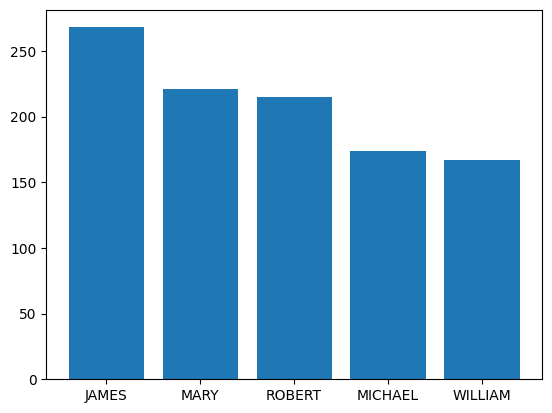

In [15]:
request = "Show a bar graph visualizing the answer to the following question:" \
        "What are the most common first names of DEM voters who voted in 2020?"

agent_executor.run(request)

Very cool! As we see, it took the problem statement, crafted the SQL query, realized it could use the results within Python, and then wrote and executed the code to draw the graph!

Let's do one more:



> Entering new AgentExecutor chain...

Thought: I need to get the data first
Action: Data
Action Input: What are the most common voting methods in 2020

> Entering new SQLDatabaseChain chain...
What are the most common voting methods in 2020 
SQLQuery: SELECT voting_method, COUNT(*) AS count FROM ncvhis29 WHERE election_desc = '11/03/2020 GENERAL' GROUP BY voting_method ORDER BY count DESC LIMIT 5;
SQLResult: [('ABSENTEE ONESTOP', 56553), ('IN-PERSON', 17872), ('ABSENTEE BY MAIL', 12568), ('ABSENTEE CURBSIDE', 2101), ('TRANSFER', 413)]
> Finished chain.

Observation: [('ABSENTEE ONESTOP', 56553), ('IN-PERSON', 17872), ('ABSENTEE BY MAIL', 12568), ('ABSENTEE CURBSIDE', 2101), ('TRANSFER', 413)]
Thought:

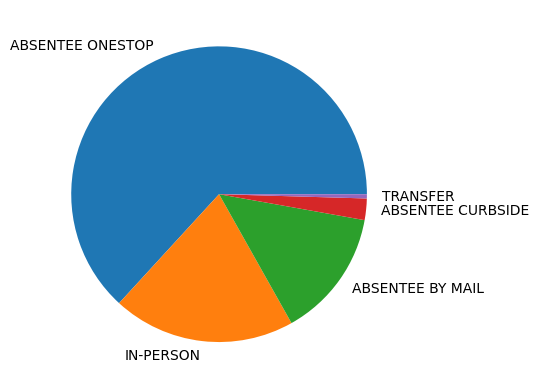

 I need to plot this data
Action: Python REPL
Action Input: import matplotlib.pyplot as plt; labels = [x[0] for x in [('ABSENTEE ONESTOP', 56553), ('IN-PERSON', 17872), ('ABSENTEE BY MAIL', 12568), ('ABSENTEE CURBSIDE', 2101), ('TRANSFER', 413)]]; sizes = [x[1] for x in [('ABSENTEE ONESTOP', 56553), ('IN-PERSON', 17872), ('ABSENTEE BY MAIL', 12568), ('ABSENTEE CURBSIDE', 2101), ('TRANSFER', 413)]]; plt.pie(sizes, labels=labels); plt.show()
Observation: 
Thought: I now know the final answer
Final Answer: A pie chart showing the most common voting methods in 2020.

> Finished chain.


'A pie chart showing the most common voting methods in 2020.'

In [16]:
agent_executor.run("Plot a pie chart of the most common voting methods in 2020")

## Some parting thoughts

That OpenAI's LLM is robust enough to craft valid SQL with minimal guidance is astounding. That it can then pipe the query results to a Python environment and build out data viz is almost impossible to believe until you see it.

That said, the examples in this Notebook are the product of many hours of trial an error. I'm sure I'll be more efficient next time around. But some of the queries just did not work. Similarly, the LLM sometimes got stuck debugging its own Python code (also astounding that it can do that!) before I decided to move on to other ideas. **This is a tool that should not be left unsupervised.** It may produce bad code. It may hallucinate. The efficiency gains are apparent, but many things just don't work yet. Similarly, the LangChain library is very much still in its infancy, and is rough around the endges.

**Most importantly:** We must continue to study and remain vigilant against the unknown biases built into the systems. Neural Networks and LLMs are already black boxes that are hard to assess. Singular platforms acting as the gateway to them only obscurs that more. And then adding all that into auto-generated code only obfuscates the risks further. This Notebook uses real voter data because its accessible and of personal interest to me. Any organizaiton hoping to use these tools for civic impact mush devote significant resources to safety, risk prevention and mitiation, and set hard ethical red lines.